## Generating Trastuzamab variants with Prodigy Protein

Prodigy Protein is a flexible and rapid tool for protein variant generation. Here we present a simple case study for a common antibody optimisation challenge in antibody discovery - sequence optimisation.

This example notebook provides a template to generate Trastuzamab variants and provides validation of the approach, demonstrating the proportion of generated variants that are binders when using Prodigy Protein. Please note that Prodigy Protein is a methodology to easily leverage Protein Language Models to suggest variants, so that its performance will always be tied to the Protein Language Model used. The human epidermal growth factor receptor 2 (HER2) antibody Trastuzamab has mutational data available, associating heavy chain CDR3 (HCDR3) sequences and whether they bind or not. Previously *Chinery et al. 2024* trained an oracle permitting the accurate prediction of HCDR3 Trastusamab variants that bind. 

It is crucial to have a performant oracle as we need to evaluate *in silico* new variants which do not have experimental data in the original deep mutation scan dataset. Here, we leverage the Trastuzamab binder oracle to measure the proportion of HCDR3 variants generated using ProdigyProtein driven by ESM2, IgBert or by a random approach (which serves as a negative control).

The generative workflow consists of several steps:

1. Loading the sampler, model and tokeniser.
2. Loading the Antibody sequence and defining the region to be edited
3. Creating the sampling configuration and inspecting the model tokeniser
4. Using the sampler to generate antibody variants

For any model it is important to inspect the dedicated tokeniser since some will introduce additional tokens into the sequence. This is true for ESM tokeniser.


| Section       | Description                                      |
|---------------|--------------------------------------------------|
| [Generating Trastuzamab variants with Prodigy Protein](#Generating-Trastuzamab-variants-with-Prodigy-Protein)  | Overview of variant generation methodology          |
| [Loading ESM2 and IgBert models, tokenisers and Trastuzamab sequence](#Loading-ESM2-and-IgBert-models,-tokeniser-and-Trastuzamab-sequence)  | Generates the tools needed for variant generation      |       |
| [Generating Trastuzamab variants](#Generating-Trastuzamab-variants)      | Prodigy Protein directed evolution of Trastuzmab          |
| [Evaluating binder yield](#Evaluating-binder-yield)  | Evaluate binder yield between ESM2 (PLM) and Random     |
| [Conclusion](#Conclusion)    | Summarize ESM2 model performance with Prodigy Protein       |
| [References](#References)    | Contains reference for Trastuzamab binding oracle used for evaluation |

Install the Prodigy Protein package using the cell below. It has one dependency, Tensorflow.

In [1]:
! pip install -q git+https://github.com/Sanofi-Public/prodigyprotein.git


For this particular analysis we will need to calculate the number of substitution mutations introduced so please install the dependencies below.

In [2]:
# install other dependencies for analysis
!pip install -q textdistance transformers

## Loading ESM2 and IgBert models, tokeniser and Trastuzamab sequence

In [14]:
from prodigyprotein import WeightedDirectedEvolutionSampler # To use samplers
from transformers import TFEsmForMaskedLM, EsmTokenizer, TFAutoModelForMaskedLM, AutoTokenizer # To load Protein Language Models
import tensorflow as tf # Manipulation of tensors 
from textdistance import levenshtein # Enumerate number of substitution mutations introduced
import joblib # Save mutants generated by Prodigy Protein 
import zipfile # Access zip file downloaded from zenodo repository
import seaborn as sns # Visualise results 
import matplotlib.pyplot as plt # Visualise results
import pandas as pd # Format variant metadata as a table
import random # Generate random substitution mutations

To validate the ProdigyProtein workflow for generating variants we will use it powered by three different methods. 

1. ESM2 650M
2. IgBert (unpaired)
3. Random

The performance of the workflow for generating antibody variants depends on the model used to derive probabilities. ProdigyProtein provides a systematic and consistent framework to ease use of models to generate variants.

### Reproducibility
You do not have to do this step but to aid reproducibility we do it here. Note it comes with a cost for runtime aswell.
You can run the cell below so that with the same inputs and hardware you will have the same result.



In [5]:
#First set the Python seed, the NumPy seed, and the TensorFlow seed.
tf.keras.utils.set_random_seed(1)

# Prevent asynchronous, non-deterministic computations on GPU 
tf.config.experimental.enable_op_determinism()

### Load Trastuzamab Ab sequence to mutate



In [6]:
# VH of Trastuzamab
sequence_heavy = '''EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDYWGQGTLVTVSS'''

In [7]:
# Define region to edit
# Both ESM2 and IgBert append a CLS token to the beginning of a sequence. To account for this we add 1 to the start index below.
seq_to_mutate = 'WGGDGFYAMD'
start = sequence_heavy.find('WGGDGFYAMD') + 1
end = start+len('WGGDGFYAMD') 
print('REGION TO CHANGE IN AB:')
print('\t' + sequence_heavy[start-1:end - 1])

REGION TO CHANGE IN AB:
	WGGDGFYAMD


In the below cell we set the sampling configuration for ProdigyProtein, since masked marginals have slightly better performance we will set this parameter to `True`. 

We are editing the HCDR3 as binding data is associated only with variants in this region. This region is 10 amino acids in length. We set `k=8` to limit the number of steps to 8 (max mutations is 8). We do not set an llr threshold allowing any sampled residue. Note that higher batch sizes will speed up computation, but will be limited by your GPU memory on your device or instance.

For this example, we aim to evaluate the proportion of binders using three strategies:
1. RANDOM
2. Protein language models ESM2
3. Antibody Language model IgBert

To help delineate differences we will need an appropriate sample size. Here, we generate 1000 variants. We use 1000, as we expect some duplicates.

In [8]:
class Config():
    
    llr_threshold=None
    masked_marginals=True
    temperature=1
    k=8
    batch_size=256
    n_variants = 1000
    seed = 0

## Generating Trastuzamab variants

### ESM2 variant generation

We will load the model and go ahead and generate the variants for Trastuzamab.

Loading the model can be done through HuggingFace (HF). Note we use the `TFEsmForMaskedLM` as we need a language modelling head on the ESM2 backbone.

**Note**:
Since we are using masked marginals, we must provide the mask token to the sampler as well (Below that the esm tokeniser prepends a CLS token 0 and appends EOS token 2 to the end of sequences).

In [ ]:
# Load ESM2 650M model and tokenizer
model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = EsmTokenizer.from_pretrained(model_name)
plm = TFEsmForMaskedLM.from_pretrained(model_name)

In [7]:
print('Mask token for PLM ESM2 650M --> {}'.format(tokenizer('<mask>')))
mask_token=32

Mask token for PLM ESM2 650M --> {'input_ids': [0, 32, 2], 'attention_mask': [1, 1, 1]}


Before running the below cell, consider your GPU memory and run a suitable batch size.

In [8]:
# RUN this cell to get ESM2 variants

# Define your input sequence
sequences = [sequence_heavy] * Config.n_variants  # Example sequence repeated

# Tokenize the sequence
tokenized = tokenizer(sequences, return_tensors="tf")

# Initialize the sampler
sampler = WeightedDirectedEvolutionSampler(temperature=Config.temperature,
                                           seed=Config.seed)


# Generate variants
esm2_variants, mutational_probabilities, logits = sampler(sequence=tokenized,
                         model=plm,
                         mask_token=mask_token,
                         max_steps=Config.k,
                         start_end_intervals=[(start, end)],
                         batch=Config.batch_size,
                         masked_marginals=Config.masked_marginals)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


8/8 [==============================] - 1328s 182s/Directed Evolution Steps


### Igbert variant generation

Load Igbert model and tokeniser

In [42]:
model_name = "Exscientia/IgBert_unpaired"
tokeniser = AutoTokenizer.from_pretrained(model_name)
plm = TFAutoModelForMaskedLM.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


A summary of IgBert is shown below.

In [46]:
plm.summary()

Model: "tf_bert_for_masked_lm_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  418881536 
                                                                 
 mlm___cls (TFBertMLMHead)   multiple                  42046494  
                                                                 
Total params: 419933214 (1.56 GB)
Trainable params: 419933214 (1.56 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can see that the mask token is 4 for the IgBert model below.

In [43]:
tokeniser.get_vocab()

{'B': 27,
 'D': 14,
 'Y': 20,
 '[PAD]': 0,
 'U': 26,
 'M': 21,
 '[MASK]': 4,
 'G': 7,
 'H': 22,
 'Q': 18,
 'O': 29,
 '[UNK]': 1,
 'K': 12,
 'I': 11,
 'L': 5,
 'E': 9,
 'A': 6,
 'T': 15,
 'F': 19,
 'Z': 28,
 '[CLS]': 2,
 '[SEP]': 3,
 'N': 17,
 'C': 23,
 'X': 25,
 'S': 10,
 'W': 24,
 'R': 13,
 'P': 16,
 'V': 8}

In [44]:
mask_token = 4

In [45]:


sequences = [sequence_heavy] * Config.n_variants 
igbert_sequences = [' '.join(sequence) for sequence in sequences] 
tokenized = tokeniser.batch_encode_plus(
    igbert_sequences, 
    add_special_tokens=True, 
    return_tensors="tf",
) 


# Initialize the sampler
sampler = WeightedDirectedEvolutionSampler(temperature=Config.temperature,
                                           seed=Config.seed)


# Generate variants
igbert_variants, mutational_probabilities, logits = sampler(sequence=tokenized,
                         model=plm,
                         mask_token=mask_token,
                         max_steps=Config.k,
                         start_end_intervals=[(start, end)],
                         batch=Config.batch_size,
                         masked_marginals=Config.masked_marginals)

8/8 [==============================] - 890s 119s/Directed Evolution Steps


In [53]:
# Checkpoint your progress, save variants generated
joblib.dump(igbert_variants, 'igbert_variants.joblib')

['igbert_variants.joblib']

**Note**:

ProdigyProtein can 'devolve' or 'step back' in the path of mutations introduced so that variants are restored to a particular step. This is useful when you want to reclaim additional variants that occurred along each variants' mutational path.

For example, you may analyse the distribution of number of mutations introduced and find it too high. You can simply run the devolve method of the sampler as shown below.

In [10]:
# sampler.devolution(
#     mutational_probabilities=mutational_probabilities, # mutational probabilities returned from sampling
#     n=step # The step where where variants should stop mutating
# )

Lets reload the respective tokenisers to detokenise the variants.

In [59]:

model_name = "facebook/esm2_t30_150M_UR50D"
esm_tokenizer = EsmTokenizer.from_pretrained(model_name)

model_name = "Exscientia/IgBert_unpaired"
igbert_tokenizer = AutoTokenizer.from_pretrained(model_name)
esm2_variants = joblib.load('esm2_variants.joblib')
igbert_variants = joblib.load('igbert_variants.joblib')

The tokeniser has a decode method to revert tokens back to amino acid residues.

In [60]:
esm2_variants = esm_tokenizer.batch_decode(esm2_variants, 
                                           skip_special_tokens=True)
igbert_variants = igbert_tokenizer.batch_decode(igbert_variants,
                                                skip_special_tokens=True)

In [61]:
# Remove whitespace in output
esm2_variants = [variant.replace(' ', '') for variant in esm2_variants]
igbert_variants = [variant.replace(' ', '') for variant in igbert_variants]

## Evaluating binder yield

To evaluate binder yield, we first need to load the oracle model. Fortunately this is publically available through Zenedo. Use the cell below to retrieve the model.

### Get oracle scores


Download model from zenodo. Unfortunately it is bundled with other files, so we will have to download the zip.

In [4]:
# ! wget "https://zenodo.org/record/10831512/files/data.zip?download=1" -O data.zip


Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/jovyan/.wget-hsts'. HSTS will be disabled.
--2025-07-21 12:59:31--  https://zenodo.org/record/10831512/files/data.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/10831512/files/data.zip [following]
--2025-07-21 12:59:31--  https://zenodo.org/records/10831512/files/data.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 2537190576 (2.4G) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.36G  10.1MB/s    in 4m 2s   

2025-07-21 13:03:33 (9.99 MB/s) - ‘data.zip’ saved [2537190576/2537190576]



The actual model is within the data directory with the base name `cnn_weights`. We can use the zipfile module to unzip the dir and extract the model.

In [17]:
with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extract("data/affinity_data/example/cnn_weights.h5", path="extracted/")


Load the oracle below. It is a small 1D CNN trained on predicting whether variants are binders or not (binary classifier).

*You can ignore the two helper functions, they are needed to preprocess amino acids into one hot encodings required by the oracle.*

In [62]:
oracle = tf.keras.models.load_model('extracted/data/affinity_data/example/cnn_weights.h5')
oracle.summary()
print('Oracle expects one hot encoded inputs --->: {}'.format(oracle.inputs))
# Define helper functions to leverage the oracle
def get_ordered_AA_one_letter_codes():
    '''
    Get list of amino acid one letter codes in alphabetical order
    '''
    return ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
            'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def oracle_tokeniser(sequences : list[list[str]]):
    '''
    '''
    amino_acids = get_ordered_AA_one_letter_codes()
    tokenised_strings = [[amino_acids.index(char) for char in seq] for seq in sequences]
    ohe_strings = tf.one_hot(tokenised_strings, depth=20)

    return ohe_strings


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 400)           40400     
                                                                 
 dropout (Dropout)           (None, 10, 400)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 400)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 300)               1080300   
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                        

The oracle expects sequences of length 10 (note the expected dimensions of the input are defined by sequence length 10 and 20 for the possible amino acids). We need extract ESM2 variants from the VH sequences output from the sampler.

Lets examine some generated variants below:

In [63]:
for var in esm2_variants[:5]:
    print(var[:start-1] + ' ' + '\033[1m' + var[start-1:end-1] + '\033[0m' + ' ' + var[end-1:])

EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR DTGSGSYYYN YWGQGTLVTVSS
EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR DGGSHSYAFD YWGQGTLVTVSS
EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR YGGSNSYAVD YWGQGTLVTVSS
EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR GGYDGDYYAD YWGQGTLVTVSS
EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR NVGWGGYYYD YWGQGTLVTVSS


In [64]:
for var in igbert_variants[:5]:
    print(var[:start-1] + ' ' + '\033[1m' + var[start-1:end-1] + '\033[0m' + ' ' + var[end-1:])

EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR HGSDGVTFYD YWGQGTLVTVSS
EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR DGGSGGGTID YWGQGTLVTVSS
EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR DRGSGSFPFD YWGQGTLVTVSS
EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR GGGYGDYRFD YWGQGTLVTVSS
EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR GGYSYGYHFD YWGQGTLVTVSS


We need to filter any tokens that are not amino acids as they cannot be evaluated by the oracle. The oracle needs to receive the tokenised amino acids shown in bold for eachs variant.


In [65]:
# Remove any sequences containing non-valid amino acids
oracle_vocab = get_ordered_AA_one_letter_codes()
oracle_vocab = set(oracle_vocab)
esm2_variants = [var for var in esm2_variants if set(var).issubset(oracle_vocab)]
igbert_variants = [var for var in igbert_variants if set(var).issubset(oracle_vocab)]

We can see one variant was removed, as a non-valid amino acid was introduced.

In [66]:
print(len(esm2_variants))

999


In [67]:
print(len(igbert_variants))

1000


In [68]:
# Remember the coordinates are -1 since we had to account for ESM2 prepending a CLS token to all sequences.
oracle_esm2_input = oracle_tokeniser(esm2_variants)
oracle_esm2_input = oracle_esm2_input[:, start-1:end-1]

oracle_igbert_input = oracle_tokeniser(igbert_variants)
oracle_igbert_input = oracle_igbert_input[:, start-1:end-1]

In [69]:
y_pred_esm2 = oracle.predict(oracle_esm2_input)
y_pred_igbert = oracle.predict(oracle_igbert_input)

 1/32 [..............................] - ETA: 8s

2025-07-25 15:59:32.636707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


32/32 [==============================] - 0s 2ms/step


### Build a dataframe with binder/non-binder and number of mutations

In [71]:
variant_results_esm2 = pd.DataFrame(
    {
        'MODEL': ['ESM2'] * len(esm2_variants),
        'VH_VARIANTS': esm2_variants,
        'VARIANT_PREDICTION_SCORE': y_pred_esm2.squeeze(),
        'BINDER_CLASSIFICATION': y_pred_esm2.squeeze() > 0.5
    }
)
print(variant_results_esm2.head())

variant_results_igbert = pd.DataFrame(
    {
        'MODEL': ['IGBERT'] * len(igbert_variants),
        'VH_VARIANTS': igbert_variants,
        'VARIANT_PREDICTION_SCORE': y_pred_igbert.squeeze(),
        'BINDER_CLASSIFICATION': y_pred_igbert.squeeze() > 0.5
    }
)
print(variant_results_igbert.head())

  MODEL                                        VH_VARIANTS  \
0  ESM2  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   
1  ESM2  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   
2  ESM2  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   
3  ESM2  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   
4  ESM2  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   

   VARIANT_PREDICTION_SCORE  BINDER_CLASSIFICATION  
0                  0.319192                  False  
1                  0.782767                   True  
2                  0.796967                   True  
3                  0.823426                   True  
4                  0.426665                  False  
    MODEL                                        VH_VARIANTS  \
0  IGBERT  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   
1  IGBERT  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   
2  IGBERT  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   
3  IGBERT  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPG

Now combine the variant tables

In [72]:
variant_results = pd.concat([variant_results_esm2, variant_results_igbert])
print(variant_results.head())

  MODEL                                        VH_VARIANTS  \
0  ESM2  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   
1  ESM2  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   
2  ESM2  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   
3  ESM2  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   
4  ESM2  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...   

   VARIANT_PREDICTION_SCORE  BINDER_CLASSIFICATION  
0                  0.319192                  False  
1                  0.782767                   True  
2                  0.796967                   True  
3                  0.823426                   True  
4                  0.426665                  False  


In [73]:
variant_results['HCDR3_VARIANT'] = variant_results['VH_VARIANTS'].str[start-1:end-1]
variant_results['NUMBER_OF_MUTATIONS'] = variant_results['HCDR3_VARIANT'].apply(lambda x: levenshtein(x, sequence_heavy[start-1:end-1]))

We will deduplicate the variants. 

In [74]:
variant_results = variant_results[~variant_results['HCDR3_VARIANT'].duplicated()]

### Include random strategy

When comparing strategies we will have to consider number of mutations introduced. 
Below after visualising the distribution of substitutions it is clear that we should only
introduce between 5-7 mutations for or random strategy or we will not have enough samples size to compare
in a statistically meaningful way.

<Axes: >

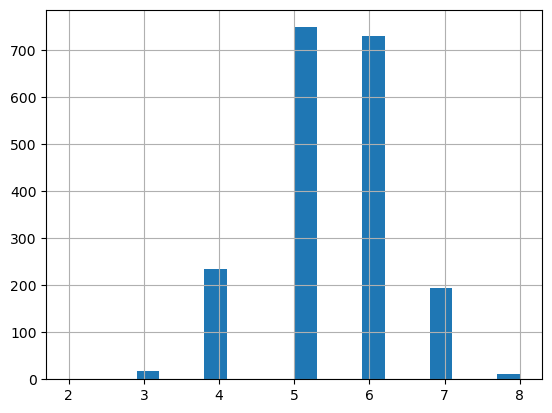

In [75]:
variant_results['NUMBER_OF_MUTATIONS'].hist(bins=20)

To ensure comparison is fair, lets create variants with similar mean mutations as ESM2 distribution.

Next we make a quick function to randomly substitute residues in the HCDR3 of Trastuzamab. Note that similar to Prodigy Protein, a new mutation must be chosen in each iteration.

In [76]:

def mutate_string(s, x, vocab):
    s = list(s)
    indices = random.sample(range(len(s)), min(x, len(s)))

    
    for i in indices:
        original = s[i]
        choices = [c for c in vocab if c != original]
        if choices:
            s[i] = random.choice(choices)
    
    return ''.join(s)


The below cell generates a 1000 random variants, generates oracle scores, classifies them as binders or non-binders and calculates the number of substitutions introduced (duplicate sequences are discarded).

In [77]:
random_variants = []
seq_to_mutate = sequence_heavy[start-1: end-1]
vocab = get_ordered_AA_one_letter_codes()
for i in range(1000):
    variant = mutate_string(s=seq_to_mutate, x=6, vocab=vocab)
    random_variants.append(variant)

# tokenise variants
random_variants_tokenised = oracle_tokeniser(random_variants)

y_pred_random = oracle.predict(random_variants_tokenised)

variant_results_random = pd.DataFrame(
    {
        'MODEL': ['RANDOM'] * Config.n_variants,
        'HCDR3_VARIANT': random_variants,
        'VARIANT_PREDICTION_SCORE': y_pred_random.squeeze(),
        'BINDER_CLASSIFICATION': y_pred_random.squeeze() > 0.5
    }
)

variant_results_random['NUMBER_OF_MUTATIONS'] = variant_results_random['HCDR3_VARIANT'].apply(lambda x: levenshtein(x, sequence_heavy[start-1:end-1]))

variant_results_random = variant_results_random[~variant_results_random['HCDR3_VARIANT'].duplicated()]

32/32 [==============================] - 0s 2ms/step


In [78]:
## Combine results into one table
all_variant_results = pd.concat([variant_results, variant_results_random])

### Visualise the results comparing random and the PLM ESM2 to generate variants.
Now we have variants from ESM2 and a random approach we can analyse the proportion of binders from each.


/tmp/ipykernel_1772/4045107262.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])


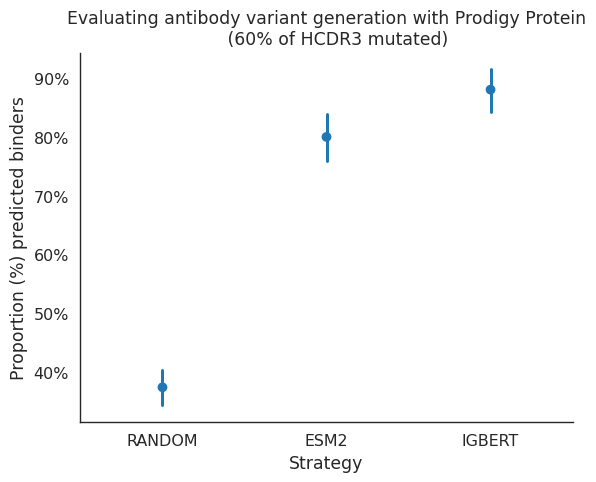

In [80]:

sns.set_style('white')
sns.set_context("paper", font_scale = 1.3)
plt.figure(figsize=(6,5))

ax = sns.pointplot(all_variant_results[all_variant_results['NUMBER_OF_MUTATIONS'] == 6], 
            x="MODEL", 
            y="BINDER_CLASSIFICATION",
              order=all_variant_results[all_variant_results['NUMBER_OF_MUTATIONS'] == 6].groupby('MODEL')['BINDER_CLASSIFICATION'].mean().sort_values(ascending=True).index.tolist(),
              linestyles='',
            estimator="mean")
sns.despine(ax=ax, right = True)
ax.set(title='Evaluating antibody variant generation with Prodigy Protein\n     (60% of HCDR3 mutated) ',
       ylabel='Proportion (%) predicted binders',
       xlabel='Strategy')
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])


plt.tight_layout()
plt.savefig('esm2-igbert-random-comparison-prodigyprotein-6mut-distance-publication-vert.svg', dpi=300)

## Conclusion

We demonstrate how Prodigy Protein can support a common challenge in antibody discovery—sequence optimisation. As expected, both IgBert and ESM2 are capable of nominating biologically plausible mutations and we easily leverage them using Prodigy Protein to engineer Trastuzamab variants. Specifically, we show that by coupling Prodigy Protein with ESM2 or IgBert we can generate approximately ~80% binders and ~90% binders respectively, for the antibody Trastuzamab (where variants contained HCDR3 which were 60% mutated). 

Prodigy Protein permits the user to easily drop in other PLM and their dedicated tokenisers into the generative AI workflow, enabling researchers to discover the best PLM for their particular engineering task. As new and more performant models are released, the performance of Prodigy Protein guided protein engineering will improve as well and we look forward to exciting PLM releases in the future.

## References

We thank the Deane laboratory for making the Trastuzamab oracle available for use. 

**Trastuzmab CNN oracle**

- Lewis Chinery, Alissa M. Hummer, Brij Bhushan Mehta, Rahmad Akbar, Puneet Rawat, Andrei Slabodkin, Khang Le Quy, Fridtjof Lund-Johansen, Victor Greiff, Jeliazko R. Jeliazkov, Charlotte M. Deane. Baselining the Buzz Trastuzumab-HER2 Affinity, and Beyond.
bioRxiv 2024.03.26.586756; doi: https://doi.org/10.1101/2024.03.26.586756

**ESM2** 

- Lin, Zeming and Akin, Halil and Rao, Roshan and Hie, Brian and Zhu, Zhongkai and Lu, Wenting and Smetanin, Nikita and Verkuil, Robert and Kabeli, Ori and Shmueli, Yaniv and et al. Evolutionary- scale prediction of atomic-level protein structure with a language model. Science, 379(6637):1123–1130, Mar 2023. doi: https://doi.org/10.1126/science.ade2574

**IgBert**

- Kenlay H, Dreyer FA, Kovaltsuk A, Miketa D, Pires D, Deane CM (2024) Large scale paired antibody language models. PLoS Comput Biol 20(12): e1012646. https://doi.org/10.1371/journal.pcbi.1012646


## Additional Requirements

Listed below are the dependencies used for this analysis:

Python version: 3.11.4

- tensorflow==2.13.0
- seaborn==0.12.2
- joblib==1.3.0
- pandas==2.0.3
- matplotlib==3.7.2
- textdistance==4.6.2

Note `random` and `zipfile` modules are part of the python standard library (they are built in).